preproc

In [160]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


df = pd.read_csv("reduced_simple_for_lab_3_parsed_data_copy.csv")
df = df[df["Median"] != "-"]
df["Median"] = [float(i.replace(",", "")) for i in df["Median"].values]
df = df[df["Median"] < 1000]

In [161]:
X = df[["Artist", "Title", "Label", "Format", "Country", "Genre", "Have", "Want", "Ratings", "Style", "Median"]].copy()


def OneHotEncodeColumn(column_name):
    column_encoder = OneHotEncoder()
    return column_encoder.fit_transform(X[column_name].values.reshape(-1, 1)).toarray()


artists = OneHotEncodeColumn("Artist")
labels = OneHotEncodeColumn("Label")
formats = OneHotEncodeColumn("Format")
countries = OneHotEncodeColumn("Country")
genres = OneHotEncodeColumn("Genre")
style = OneHotEncodeColumn("Style")
scaler = StandardScaler()
X[["Have", "Want", "Ratings", "Median"]] = scaler.fit_transform(X[["Have", "Want", "Ratings", "Median"]])

X[["Have", "Want", "Ratings", "Median"]].describe()

,Have,Want,Ratings,Median
count,9.776000e+03,9.776000e+03,9.776000e+03,9.776000e+03
mean,5.814589e-18,-3.488753e-17,9.303342e-17,1.162918e-17
std,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00
min,-6.896403e-01,-6.334888e-01,-8.785277e-01,-7.544175e-01
25%,-5.647559e-01,-5.073170e-01,-5.774535e-01,-5.410095e-01
50%,-3.649878e-01,-3.156893e-01,-3.189555e-01,-3.556174e-01
75%,1.283289e-01,9.600547e-02,1.949993e-01,1.058788e-01
max,1.444437e+01,1.773839e+01,2.108164e+01,7.997614e+00


In [162]:
X = np.concatenate((genres, style, X[["Have", "Want", "Ratings", "Median"]].values), axis=1)
y = np.argmax(formats, axis=1)

In [163]:
X_train, X_val, y_train, y_val = train_test_split(X, y)

my impl

In [164]:
def uniform_kernel(x):
    return 1 / 2 if abs(x) <= 1 else 0


def gaussian_kernel(x):
    return 1 / math.sqrt(2 * math.pi) * math.exp(-x ** 2 / 2)


def epanechnikov_kernel(x):
    return 3 / 4 * (1 - x ** 2) if abs(x) <= 1 else 0


def triangular_kernel(x):
    return 1 - abs(x) if abs(x) <= 1 else 0

In [166]:
from sklearn.neighbors import NearestNeighbors

class MyKnn:

    def __init__(self, k=None, h=None, kernel="uniform", metric="cosine", include_point=True):
        self.weights = None
        self.X = None
        self.y = None
        self.finder = None
        self.k = k
        self.h = h
        self.include_point = include_point
        if k is None and h is None:
            raise ValueError("k or h must be not None")
        if k is not None and h is not None:
            raise ValueError("only k or h can be set")
        self.kernel = {"uniform": uniform_kernel, "gaussian": gaussian_kernel, "epanechnikov": epanechnikov_kernel,
                       "triangular": triangular_kernel}[kernel]
        self.metric = metric

    def fit(self, X, y, weights=None):
        self.X = X
        self.y = y
        self.weights = weights
        if self.h:
            self.finder = NearestNeighbors(algorithm='auto', radius=self.h, metric=self.metric).fit(X)
        else:
            self.finder = NearestNeighbors(n_neighbors=self.k + 1, algorithm='auto', metric=self.metric).fit(X)

    def predict(self, x):
        distances, indices = self.finder.kneighbors(x)
        res = []
        for l, ind in enumerate(indices):
            if self.h:
                h = self.h
            else:
                h = distances[l][-1]
            tmp = np.zeros(np.max(self.y) + 1)
            if self.include_point:
                tmp[self.y[ind[0]]] = self.kernel(0) * (self.weights[ind[0]] if self.weights else 1)
                
            for i in range(1, len(ind) - 1):
                tmp[self.y[ind[i]]] += self.kernel(distances[l][i] / h) * (self.weights[ind[i]] if self.weights else 1)
            res.append(np.argmax(tmp))
        return res

    def closest(self, x):
        distances, indices = self.finder.kneighbors(x)
        return distances, indices

    def get_params(self, deep=True):
        return {"k": self.k,
                "h": self.h,
                "kernel": self.kernel,
                "metric": self.metric}


In [184]:
import optuna


def objective(trial):
    kernel = trial.suggest_categorical('kernel', ["uniform", "gaussian", "epanechnikov", "triangular"])
    metric = trial.suggest_categorical("metric", ["euclidean", "cosine", "manhattan", "minkowski"])

    fixed = trial.suggest_categorical('fixed', [True, False])
    if fixed:
        h = trial.suggest_float('h', 0, 20)
        model = MyKnn(h=h, kernel=kernel, metric=metric)
    else:
        k = trial.suggest_int('k', 1, 151)
        model = MyKnn(k=k, kernel=kernel, metric=metric)

    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    score = accuracy_score(pred, y_val)
    return score


study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=100)

my_best_params = study.best_params
my_best_score = study.best_value

print("Best score:", my_best_score)
print("Best parameters:", my_best_params)

[I 2024-04-04 12:41:27,542] A new study created in memory with name: no-name-ac0712fa-6bbb-4f3d-8afd-581c1cdd0018
[I 2024-04-04 12:41:27,851] Trial 0 finished with value: 0.765139116202946 and parameters: {'kernel': 'epanechnikov', 'metric': 'euclidean', 'fixed': False, 'k': 124}. Best is trial 0 with value: 0.765139116202946.
[I 2024-04-04 12:41:28,516] Trial 1 finished with value: 0.7479541734860884 and parameters: {'kernel': 'epanechnikov', 'metric': 'manhattan', 'fixed': True, 'h': 13.831996798732828}. Best is trial 0 with value: 0.765139116202946.
[I 2024-04-04 12:41:28,766] Trial 2 finished with value: 0.7675941080196399 and parameters: {'kernel': 'epanechnikov', 'metric': 'minkowski', 'fixed': False, 'k': 76}. Best is trial 2 with value: 0.7675941080196399.
[I 2024-04-04 12:41:29,249] Trial 3 finished with value: 0.766366612111293 and parameters: {'kernel': 'triangular', 'metric': 'cosine', 'fixed': False, 'k': 38}. Best is trial 2 with value: 0.7675941080196399.
[I 2024-04-04 1

Best score: 0.7720949263502455
Best parameters: {'kernel': 'gaussian', 'metric': 'manhattan', 'fixed': False, 'k': 123}


In [185]:
import optuna
from sklearn.neighbors import KNeighborsClassifier


def objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 151)
    weights = trial.suggest_categorical('weights', ["uniform", "distance"])
    metric = trial.suggest_categorical("metric", ["euclidean", "cosine", "manhattan", "minkowski"])

    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    score = accuracy_score(pred, y_val)
    return score


study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=100)

lib_best_params = study.best_params
lib_best_score = study.best_value

print("Best score:", lib_best_score)
print("Best parameters:", lib_best_params)

[I 2024-04-04 12:42:34,584] A new study created in memory with name: no-name-4f572ef8-1090-46c7-8672-f79b9b2c0cd1
[I 2024-04-04 12:42:34,703] Trial 0 finished with value: 0.7680032733224222 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 0 with value: 0.7680032733224222.
[I 2024-04-04 12:42:34,855] Trial 1 finished with value: 0.765139116202946 and parameters: {'n_neighbors': 87, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 0 with value: 0.7680032733224222.
[I 2024-04-04 12:42:34,963] Trial 2 finished with value: 0.7675941080196399 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 0 with value: 0.7680032733224222.
[I 2024-04-04 12:42:35,533] Trial 3 finished with value: 0.7712765957446809 and parameters: {'n_neighbors': 115, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 3 with value: 0.7712765957446809.
[I 2024-04-04 12:42:35,993] Trial 4 finished with value: 0.

Best score: 0.7741407528641571
Best parameters: {'n_neighbors': 43, 'weights': 'distance', 'metric': 'manhattan'}


In [186]:
def draw_plot(X_train, y_train, X_val, y_val, model_constructor, args):
    res = []
    for i in tqdm(args):
        model = model_constructor(i)
        model.fit(X_train, y_train)
        score_train = accuracy_score(y_train, model.predict(X_train))
        score_val = accuracy_score(y_val, model.predict(X_val))
        res.append([score_train, score_val])

    plt.figure(figsize=(12, 4))
    print([i[0] for i in res])
    print([i[1] for i in res])
    plt.subplot(131)
    plt.plot(args, [i[0] for i in res])
    plt.title("train")

    plt.subplot(132)
    plt.plot(args, [i[1] for i in res])
    plt.title("valid")

    plt.tight_layout()
    plt.show()


def my_constructor(n):
    if my_best_params['fixed']:
        return MyKnn(h=n, kernel=my_best_params["kernel"], metric=my_best_params["metric"])
    return MyKnn(k=n, kernel=my_best_params["kernel"], metric=my_best_params["metric"])

def lib_constructor(n):
    return KNeighborsClassifier(n_neighbors=n, weights=lib_best_params["weights"], metric=lib_best_params["metric"])

100%|██████████| 10/10 [00:24<00:00,  2.44s/it]

[1.0, 0.7917348608837971, 0.7797326786688489, 0.7692307692307693, 0.7641843971631206, 0.7630932896890343, 0.7617294053464266, 0.7615930169121659, 0.7614566284779051, 0.7585924713584288]
[0.703355155482815, 0.763911620294599, 0.7692307692307693, 0.7684124386252046, 0.7716857610474632, 0.7712765957446809, 0.7700490998363339, 0.7704582651391162, 0.7704582651391162, 0.7716857610474632]


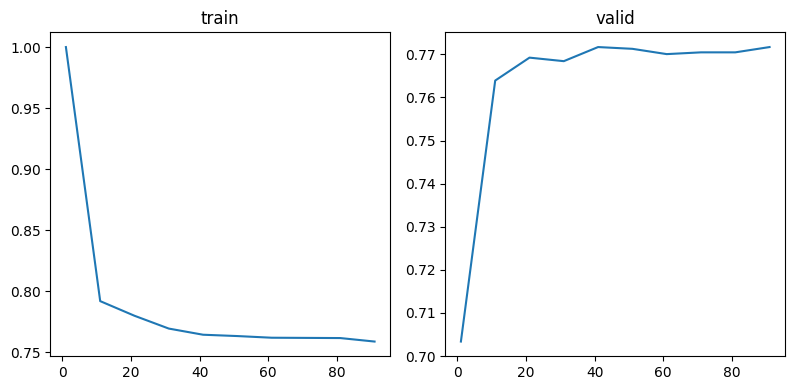

In [187]:
draw_plot(X_train, y_train, X_val, y_val, my_constructor, range(1, 101, 10))

100%|██████████| 10/10 [00:21<00:00,  2.13s/it]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.703355155482815, 0.7659574468085106, 0.7696399345335515, 0.7712765957446809, 0.7741407528641571, 0.7729132569558101, 0.7708674304418985, 0.7708674304418985, 0.7708674304418985, 0.7712765957446809]


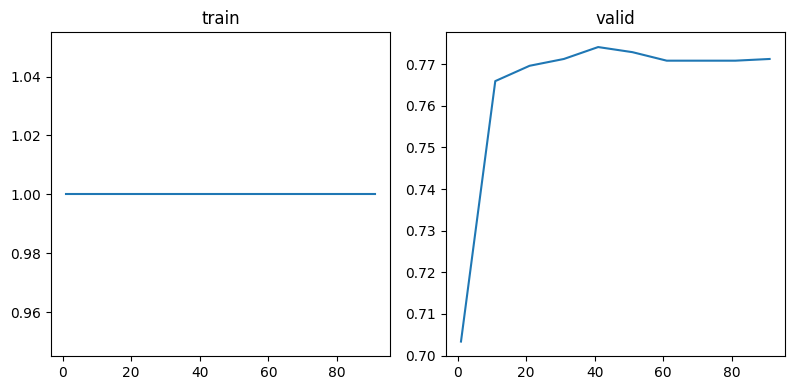

In [188]:
draw_plot(X_train, y_train, X_val, y_val, lib_constructor, range(1, 101, 10))

In [189]:
def lowess(X, y):
    weights = []
    model = MyKnn(k=40, kernel=my_best_params["kernel"], metric=my_best_params["metric"], include_point=False)
    model.fit(X, y)
    for i in tqdm(range(len(X))):
        weights.append(gaussian_kernel(y[i] - model.predict([X[i]])[0]))
    return weights

In [190]:
w = lowess(X_train, y_train)

100%|██████████| 7332/7332 [00:07<00:00, 956.22it/s]


In [191]:
print(w)

[0.3989422804014327, 5.520948362159764e-88, 0.3989422804014327, 5.520948362159764e-88, 0.3989422804014327, 0.3989422804014327, 0.3989422804014327, 1.758749542595104e-71, 0.3989422804014327, 0.3989422804014327, 0.3989422804014327, 7.004182134318583e-64, 5.520948362159764e-88, 0.3989422804014327, 5.520948362159764e-88, 0.3989422804014327, 5.520948362159764e-88, 0.3989422804014327, 0.3989422804014327, 0.3989422804014327, 0.3989422804014327, 5.520948362159764e-88, 0.3989422804014327, 0.3989422804014327, 0.3989422804014327, 0.3989422804014327, 5.520948362159764e-88, 0.3989422804014327, 0.3989422804014327, 0.3989422804014327, 0.3989422804014327, 0.3989422804014327, 0.3989422804014327, 1.758749542595104e-71, 5.520948362159764e-88, 0.3989422804014327, 0.3989422804014327, 0.3989422804014327, 0.3989422804014327, 0.3989422804014327, 0.3989422804014327, 0.3989422804014327, 0.3989422804014327, 5.520948362159764e-88, 0.3989422804014327, 0.3989422804014327, 0.3989422804014327, 0.3989422804014327, 0.3

In [193]:
if my_best_params['fixed']:
   model = MyKnn(h=my_best_params["h"], kernel=my_best_params["kernel"],
              metric=my_best_params["metric"]) 
else:
    model = MyKnn(k=my_best_params["k"], kernel=my_best_params["kernel"],
              metric=my_best_params["metric"])
model.fit(X_train, y_train, weights=w)

In [194]:
accuracy_score(y_val, model.predict(X_val))

0.7688216039279869

In [195]:
mask = np.ones(len(X_train), dtype=bool)
percentile = np.percentile(w, 25)
for i in range(len(mask)):
    if w[i] < percentile:
        mask[i] = False
X_train_fil, y_train_fil = X_train[mask], y_train[mask]
model = KNeighborsClassifier(n_neighbors=lib_best_params["n_neighbors"], weights=lib_best_params["weights"],
                             metric=lib_best_params["metric"])
model.fit(X_train_fil, y_train_fil)
pred = model.predict(X_val)

In [196]:
accuracy_score(pred, y_val)

0.7684124386252046